MNIST

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([transforms.Resize((28,28)), # for external images (like the 5 for the test)
                                transforms.ToTensor(), # convert numpy values in the range from 0 to 255 in to normal values (from 0.0 to 1.0)
                                # normalize values for each tensor, first brakets mean that we want to use to normalize channel, second brakets is standard deviation
                                # beacuase we want to convert from 0 to 1 to -1 1
                                # in fact to convert 0 we have: (0 - 0.5)/0.5 = -1
                                # for 1 we have: (1 - 0.5)/0.5 = 1
                                transforms.Normalize((0.5,), (0.5,)) 
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # 20% of the traing set

# training loader to feed training in the correct way
# shuffle is important to avoid local minimum
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)# swap axis 0 wit 1, and then the 1 with axis 2
  # from shape (1,28,28) to (28,28,1)
  print(image.shape)
  #de-normalize
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  #to ensure the range is between 0 and 1 we use clip
  image = image.clip(0,1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


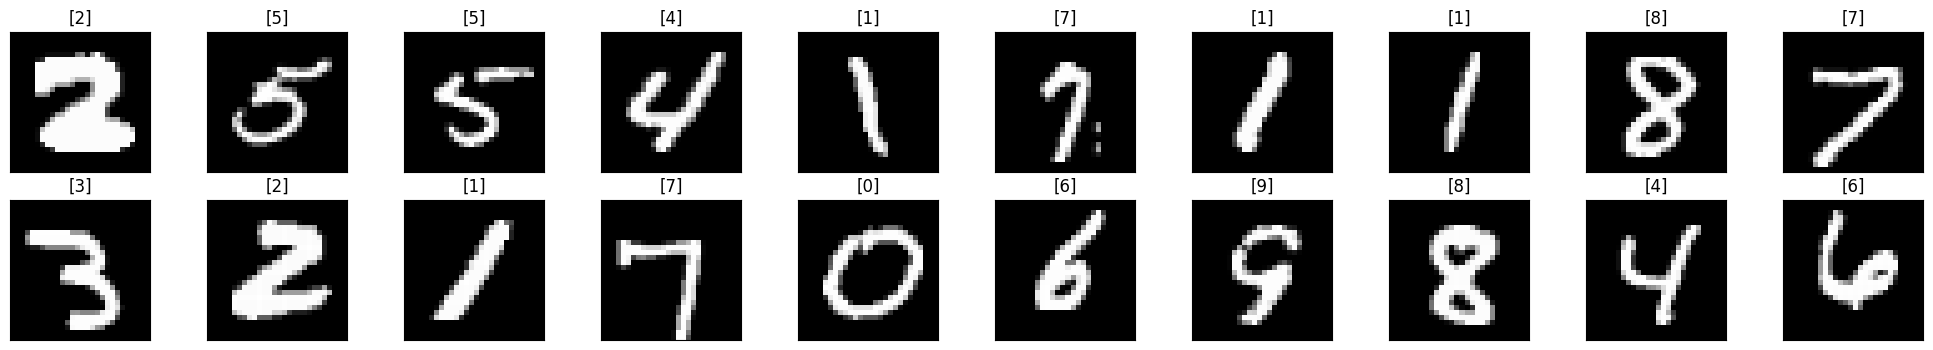

In [ ]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) #x/yticks used to remove grids
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
  # Lavoriamo con data set multiclasse quindi non utilizziamo nessuna funzione di attivazione.
  # Otterremo quindi un rawoutput chiamato score
  # E' importante quando stiamo per calcolare la cross entropy loss di un dataset multiclasse
  # nn.CrossEntropyLoss, è combinazione di log_softmax + NLLLoss() (negative log likehood loss)
  # è usato per la classificazione multiclasse
  # il log permette di evitare errori di approssimazione

In [ ]:
model = Classifier(784, 125, 65, 10) # 10 numero di classi
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# Sarà necessario utilizzare un learning rate basso visto l'ammontare di dati
# Usare il correto learning rate è fondamentale (rivedi video o cercare appunti online)

In [ ]:
epochs = 15
running_loss_history = [] #loss history through epochs
running_corrects_history = [] # accuracy history
# we need validation history to check overfitting
val_running_loss_history = [] 
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: #batch iteration
    inputs = inputs.view(inputs.shape[0], -1) # 1,28,28 flatten it into a single row
    outputs = model(inputs)
    loss = criterion(outputs, labels) # calculated with cross-entropy
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1) # primo valore ritornato
    # è lo score (non ci interessa), mentre il secondo è l'indice, quindi
    # l'etichetta predetta di ogni immagine predetta    
    running_loss += loss.item() # salviamo il loss dell'intero batch, e acculiamo i loss di tutti i batch
    running_corrects += torch.sum(preds == labels.data) # numero di etichette identiche

  else: # quando il ciclo dei batch è concluso
    with torch.no_grad(): #to save memory, set all the requires grad flags to be false
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader) #average loss of the epoch
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss) #aggiungiamo al running loss
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print('epoch :', (e+1)) # print epoch
    
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    # placeholder for a floatig point
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9315, acc 77.9833 
validation loss: 0.4050, validation acc 89.2500 
epoch : 2
training loss: 0.3678, acc 89.6033 
validation loss: 0.3175, validation acc 90.8200 
epoch : 3
training loss: 0.3084, acc 90.9900 
validation loss: 0.2849, validation acc 91.9200 
epoch : 4
training loss: 0.2751, acc 91.9333 
validation loss: 0.2537, validation acc 92.8300 
epoch : 5
training loss: 0.2499, acc 92.6833 
validation loss: 0.2329, validation acc 93.2900 
epoch : 6
training loss: 0.2284, acc 93.3883 
validation loss: 0.2126, validation acc 93.8300 
epoch : 7
training loss: 0.2110, acc 93.8817 
validation loss: 0.1985, validation acc 94.1900 
epoch : 8
training loss: 0.1955, acc 94.4017 
validation loss: 0.1910, validation acc 94.4100 
epoch : 9
training loss: 0.1825, acc 94.6500 
validation loss: 0.1817, validation acc 94.6600 
epoch : 10
training loss: 0.1701, acc 95.0750 
validation loss: 0.1662, validation acc 94.9900 
epoch : 11
training loss: 0.1602, acc 95.2767 
va

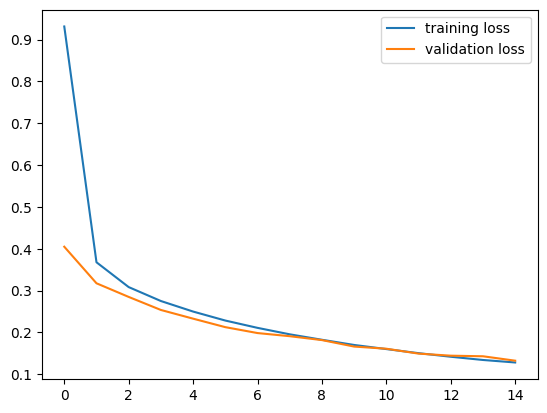

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

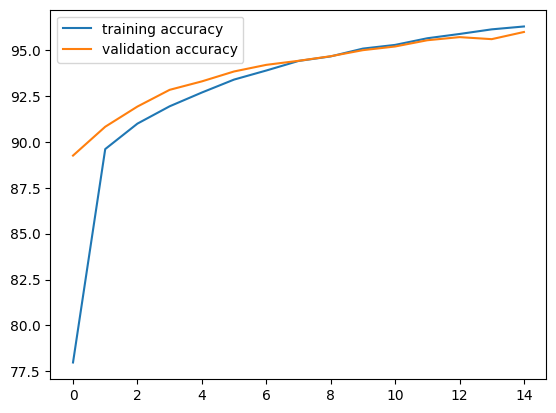

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
!pip3 install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import PIL.ImageOps

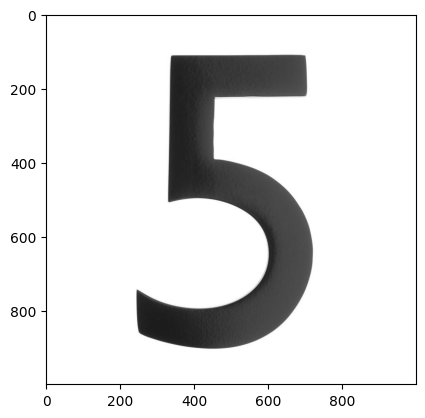

In [ ]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


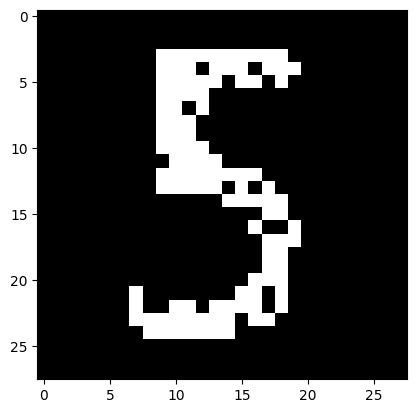

In [ ]:
# pre-process of the image
img = PIL.ImageOps.invert(img)
img = img.convert('1')#convert into a binary image
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


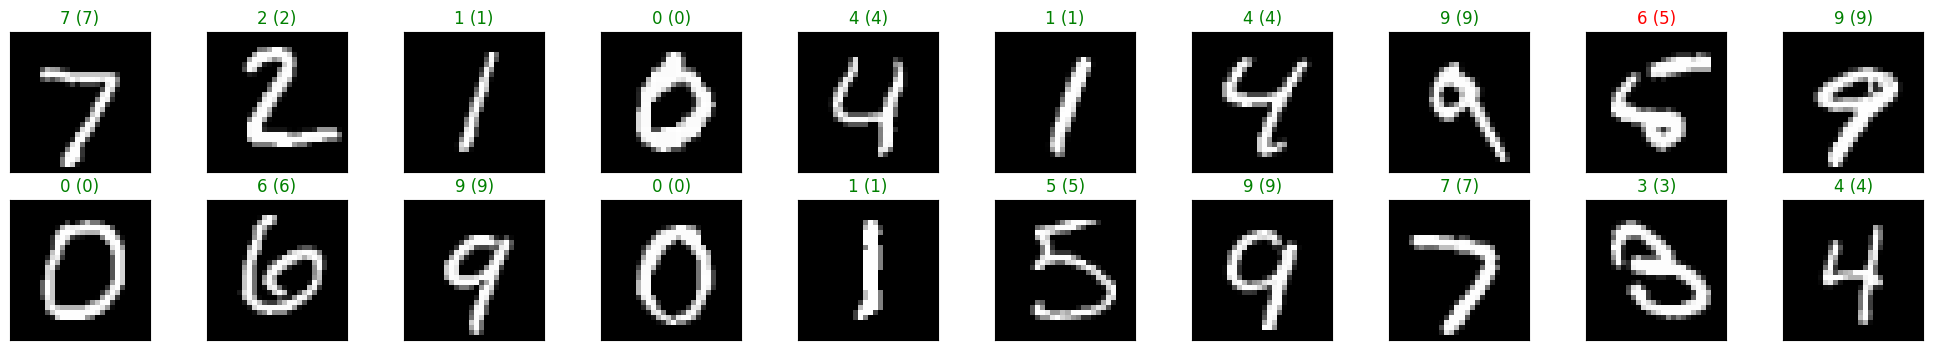

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))